In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#from keras.applications.vgg19 import preprocess_input
import cv2
from scipy import io
from nst_utils import *
import cv2
import matplotlib

# Load pretrained VGG-19 model
Neural Style Transfer (NST) uses a pretrained model (in the original paper they use VGG19) and builds on top of that
The model can be downloaded from:
https://www.kaggle.com/teksab/imagenetvggverydeep19mat

In [0]:

model = load_vgg_model(r'your-path/imagenet-vgg-verydeep-19.mat')

# Neural Style Transfer
There are three steps for building the NST algorithm:
<ul>
    <li>Build the content function $J_{content}(C,G)$</li>
    <li>Build the style function $J_{style}(S,G)$</li>
    <li>Build $J(G) = \alpha J_{style}(S,G) + \beta J_{style}(S,G)$</li>
</ul>

## 1. Content cost
I'm going to use the Casino of Constanta as a content image throughout the notebook

(702, 994, 3)


(-0.5, 993.5, 701.5, -0.5)

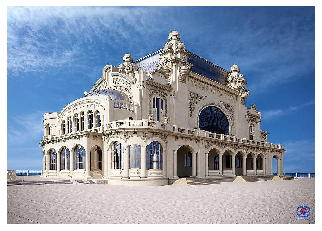

In [24]:

cta_casino = plt.imread('your-path')
print(cta_casino.shape)
plt.imshow(cta_casino)
plt.axis('off')


### The content cost function is defined as:
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In the above formula G stands for the generated image and C, the content image. Our goal is to make sure that the generated image matches the content image i.e have similar content. We are going to use some layer's activations (of the pretrained network) to represent the content image (in practice, it is usually chosen a layer in the middle of the network - neither too shallow nor too deep). We set C as input to the pretrained network and run forward propagation, obtaining $a^{(C)}$, a tensor with dimension $n_H \times n_W \times n_C$. We do the same thing for the generated image and obtain $a^{(G)}$.

In [0]:
def content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list() # get dimensions
    
    a_C = tf.reshape(a_C, [n_C, -1])
    a_G = tf.reshape(a_G, [n_C, -1])
    print(a_C.shape)
    J_content = tf.reduce_sum((a_C - a_G) ** 2) * 1 / (4 * n_H * n_W * n_C)
    
    return J_content

## 2. Style cost
For the style image, i'm going to use Van Gogh's Starry Night

(702, 994, 3)


(-0.5, 993.5, 701.5, -0.5)

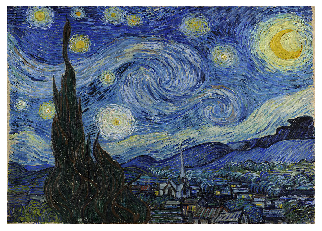

In [25]:
van_gogh = plt.imread('your-path')
van_gogh = cv2.resize(van_gogh, (cta_casino.shape[1], cta_casino.shape[0]), interpolation=cv2.INTER_CUBIC)
print(van_gogh.shape)
plt.imshow(van_gogh)
plt.axis('off')


### 2.1 Style matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 


One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image. 


In [0]:
def gram_matrix(A):
    
    return tf.matmul(A, tf.transpose(A))

### 2.2 The style cost function is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.

In [0]:
def style_cost(a_S, a_G):
        
    m, n_H, n_W, n_C = a_G.get_shape().as_list() # get dimensions
    
    a_S = tf.reshape(a_S, [n_C, -1])
    a_G = tf.reshape(a_G, [n_C, -1])
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style = tf.reduce_sum(tf.square(tf.subtract(GS,GG))) * (1 / (4 * (n_H * n_W) ** 2 * n_C ** 2))
    
    return J_style

#### The above function computes the cost for the activations of a single hidden layer. To get better results, we'll use several hidden layers.

In [0]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [0]:
def style_cost_layers(model, STYLE_LAYERS):
    
    J_style = 0
    
    for layer, coeff in STYLE_LAYERS:
        
        out = model[layer]
        
        a_S = sess.run(out)
        
        a_G = out
        
        J_style = style_cost(a_S, a_G)
        
        J_style += coeff * J_style
        
    return J_style


## 3. Defining the total cost






$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [0]:
def total_cost(J_content, J_style, alpha, beta):
    
    J = alpha * J_content + beta * J_style
    
    return J

## 4. Optimization

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [11]:
japan_spring = np.reshape(japan_spring, ((1,) + japan_spring.shape))
content_img = japan_spring.copy().astype('float32')
content_img = content_img - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

print(content_img.shape)

(1, 668, 1000, 3)


In [12]:
abstract = np.reshape(abstract, ((1,) + abstract.shape))
style_img = abstract.copy().astype('float32')
style_img = style_img - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

print(style_img.shape)

(1, 668, 1000, 3)


In [13]:
noise_image = np.random.uniform(-10, 10, (1, japan_spring.shape[1], japan_spring.shape[2], 3)).astype('float32')
generated_img = noise_image * 0.98 + content_img * (1 - 0.98)
print(generated_img.shape)

(1, 668, 1000, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


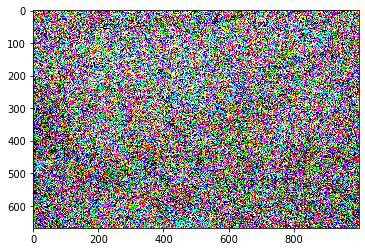

In [14]:
plt.imshow(generated_img[0])

In [15]:
model = load_vgg_model(r'your-path/pretrained_model/imagenet-vgg-verydeep-19.mat')

In [0]:
sess.run(model['input'].assign(content_img))

out = model['conv4_2']

a_C = sess.run(out)


a_G = out

In [17]:
J_content = content_cost(a_C, a_G)
sess.run(model['input'].assign(style_img))

J_style = style_cost_layers(model, STYLE_LAYERS)


(512, 10500)


In [18]:
print(J_style)

Tensor("add_20:0", shape=(), dtype=float32)


In [19]:
J = total_cost(J_content, J_style, 10, 40)
optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def model_nn(sess, input_image, num_iterations = 350):
    
    
    sess.run(tf.global_variables_initializer())

    sess.run(model['input'].assign(input_image))
    
    
    for i in range(num_iterations):
    
        
        sess.run(train_step)
 
        generated_image = sess.run(model['input'])

        if i % 50 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
           
    generated_image = generated_image + np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    
    generated_image = np.clip(generated_image[0], 0, 255).astype('uint8')

    plt.imsave('your-path/japan_generated.jpeg', generated_image)


    
    return generated_image[0]

In [23]:
model_nn(sess, generated_img)

Iteration 0 :
total cost = 242015.17
content cost = 18191.24
style cost = 1502.5691
Iteration 50 :
total cost = 29017.348
content cost = 2536.3582
style cost = 91.34414
Iteration 100 :
total cost = 15722.095
content cost = 1206.2837
style cost = 91.48145
Iteration 150 :
total cost = 11800.881
content cost = 813.3121
style cost = 91.694016
Iteration 200 :
total cost = 10011.535
content cost = 634.69446
style cost = 91.61476
Iteration 250 :
total cost = 9007.12
content cost = 535.11774
style cost = 91.398575
Iteration 300 :
total cost = 8361.541
content cost = 471.65152
style cost = 91.12564


array([[ 74,   0,  65],
       [126,   0, 100],
       [143,  52, 141],
       ...,
       [ 98,  70,   5],
       [134,  72,   0],
       [168, 150, 147]], dtype=uint8)